In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import json

In [2]:
from models import od_dq_base, dq_agg_sum, dq_agg_view
from base_queries import run_stmt
import env_vars as ev

Environment variables loaded successfully.
All Required Environment variables are loaded.


In [3]:
from sqlalchemy import Select, func, or_, desc

In [79]:
! pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.5 MB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 21.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 21.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.0 MB/s eta 0:00:0000:0100:01
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)


In [80]:
import seaborn as sns

## Top Cards 

### Total Orders with Delta

In [4]:
dt_val = "2024-06-25"

In [5]:
curr_dt = datetime.strptime(dt_val, "%Y-%m-%d")

In [6]:
prev_dt = curr_dt - timedelta(days=1)

In [7]:
top_cards = (
    Select(
        dq_agg_sum.c.ord_date.label("Order_Date"),
        func.sum(dq_agg_sum.c.total_orders).label("Total_Orders"),
        func.sum(dq_agg_sum.c.total_canceled_orders).label("Cancelled_Orders")
    ).where(or_(dq_agg_sum.c.ord_date == curr_dt, dq_agg_sum.c.ord_date == prev_dt))
    .group_by(dq_agg_sum.c.ord_date)
    .order_by(desc(dq_agg_sum.c.ord_date))
)

In [8]:
print(top_cards)

SELECT testing.aggregated_sum.ord_date AS "Order_Date", sum(testing.aggregated_sum.total_orders) AS "Total_Orders", sum(testing.aggregated_sum.total_canceled_orders) AS "Cancelled_Orders" 
FROM testing.aggregated_sum 
WHERE testing.aggregated_sum.ord_date = :ord_date_1 OR testing.aggregated_sum.ord_date = :ord_date_2 GROUP BY testing.aggregated_sum.ord_date ORDER BY testing.aggregated_sum.ord_date DESC


In [9]:
res = run_stmt(top_cards)

In [10]:
df_temp = pd.DataFrame(res)

In [11]:
# df_temp.loc[:,["Order_Date"]] = df_temp["Order_Date"].astype()
df_temp.loc[:,"Total_Orders"] = df_temp["Total_Orders"].astype(int)
df_temp.loc[:,"Cancelled_Orders"] = df_temp["Cancelled_Orders"].astype(int)

In [12]:
df_temp["Cancel_percentage"] = df_temp["Cancelled_Orders"] / df_temp["Total_Orders"]

In [13]:
df_temp["Completed_percentage"] = (df_temp["Total_Orders"] - df_temp["Cancelled_Orders"])/ df_temp["Total_Orders"]

In [14]:
df_temp

,Order_Date,Total_Orders,Cancelled_Orders,Cancel_percentage,Completed_percentage
0,2024-06-25,200731,3796,0.018911,0.981089
1,2024-06-24,209041,3582,0.017135,0.982865


In [15]:
def calc_metrices(df: pd.DataFrame, col_name: str):
    old_val = np.round(df[col_name][1],4)
    new_val = np.round(df[col_name][0],4)
    diff = new_val - old_val
    per_diff = np.round((diff/old_val)*100,4)
    return new_val, diff, per_diff

In [16]:
tt, td, tp = calc_metrices(df_temp, "Total_Orders")

In [17]:
total_orders = {
    "title":"Total Orders",
    "count": str(tt),
    "increased" : False if td < 0 else True,
    "variancePercentage" : str(tp),
    "varianceText": "vs Yesterday"
}

In [18]:
tc, cd, cp = calc_metrices(df_temp, "Cancelled_Orders")

In [19]:
total_cancellation = {
    "title":"Cancelled Orders",
    "count": str(tc),
    "increased" : False if cd < 0 else True,
    "variancePercentage" : str(cp),
    "varianceText": "vs Yesterday"
}

In [20]:
cct, ccd, ccp = calc_metrices(df_temp, "Cancel_percentage")

In [21]:
cct

0.0189

In [22]:
cancel_percentage = {
    "title":"Order Cancellation %",
    "count": str(cct),
    "increased" : False if ccd < 0 else True,
    "variancePercentage" : str(ccp),
    "varianceText": "vs Yesterday"
}

In [23]:
cot, cod, cop = calc_metrices(df_temp, "Completed_percentage")

In [24]:
compl_percentage = {
    "title":"Order Completion %",
    "count": str(cot),
    "increased" : False if cod < 0 else True,
    "variancePercentage" : str(cop),
    "varianceText": "vs Yesterday"
}

In [25]:
final_list = [total_orders, total_cancellation, cancel_percentage,compl_percentage]

In [26]:
final_list

[{'title': 'Total Orders',
  'count': '200731',
  'increased': False,
  'variancePercentage': '-3.9753',
  'varianceText': 'vs Yesterday'},
 {'title': 'Cancelled Orders',
  'count': '3796',
  'increased': True,
  'variancePercentage': '5.9743',
  'varianceText': 'vs Yesterday'},
 {'title': 'Order Cancellation %',
  'count': '0.0189',
  'increased': True,
  'variancePercentage': '10.5263',
  'varianceText': 'vs Yesterday'},
 {'title': 'Order Completion %',
  'count': '0.9811',
  'increased': False,
  'variancePercentage': '-0.1831',
  'varianceText': 'vs Yesterday'}]

## Missing Columns Completed

In [27]:
col_sum_comp = (
    Select(
        dq_agg_view.c.ord_date, 
        func.sum(dq_agg_view.c.total_orders).label("total_orders"),
        func.sum(dq_agg_view.c.null_fulfilment_id).label("null_fulfilment_id"),
        func.sum(dq_agg_view.c.null_net_tran_id).label("null_net_tran_id"),
        func.sum(dq_agg_view.c.null_qty.label("null_qty")),
        func.sum(dq_agg_view.c.null_itm_fulfilment_id).label("null_itm_fulfilment_id"),
        func.sum(dq_agg_view.c.null_del_pc).label("null_del_pc"),
        func.sum(dq_agg_view.c.null_created_date_time).label("null_created_date_time"),
        func.sum(dq_agg_view.c.null_domain).label("null_domain"),
        func.sum(dq_agg_view.c.null_del_cty).label("null_del_cty"),
        func.sum(dq_agg_view.c.null_ord_stats).label("null_ord_stats"),
        func.sum(dq_agg_view.c.null_fulfil_status).label("null_fulfil_status"),
        func.sum(dq_agg_view.c.null_itm_cat).label("null_itm_cat"),
        func.sum(dq_agg_view.c.null_cat_cons).label("null_cat_cons"),
        func.sum(dq_agg_view.c.null_sell_pincode).label("null_sell_pincode"),
        func.sum(dq_agg_view.c.null_prov_id).label("null_prov_id"),
        func.sum(dq_agg_view.c.null_itm_id).label("null_itm_id"),
        func.sum(dq_agg_view.c.null_sell_np).label("null_sell_np"),
        func.sum(dq_agg_view.c.null_net_ord_id).label("null_net_ord_id"),
        func.sum(dq_agg_view.c.null_sell_cty).label("null_sell_cty"),
    ).where(or_(dq_agg_view.c.ord_date==curr_dt, dq_agg_view.c.ord_date==prev_dt))
    .group_by(dq_agg_view.c.ord_date)
    .order_by(desc(dq_agg_view.c.ord_date))
)

In [28]:
col_sum_canc = (
    Select(
        dq_agg_view.c.ord_date, 
        func.sum(dq_agg_view.c.total_canceled_orders).label("total_canceled_orders"),
        func.sum(dq_agg_view.c.null_cans_code).label("null_cans_code"),
        func.sum(dq_agg_view.c.null_cans_dt_time).label("null_cans_dt_time")
    ).where(or_(dq_agg_view.c.ord_date==curr_dt, dq_agg_view.c.ord_date==prev_dt))
    .group_by(dq_agg_view.c.ord_date)
    .order_by(desc(dq_agg_view.c.ord_date))
)

In [29]:
print(col_sum_comp)

SELECT testing.aggregated_view.ord_date, sum(testing.aggregated_view.total_orders) AS total_orders, sum(testing.aggregated_view.null_fulfilment_id) AS null_fulfilment_id, sum(testing.aggregated_view.null_net_tran_id) AS null_net_tran_id, sum(testing.aggregated_view.null_qty) AS sum_1, sum(testing.aggregated_view.null_itm_fulfilment_id) AS null_itm_fulfilment_id, sum(testing.aggregated_view.null_del_pc) AS null_del_pc, sum(testing.aggregated_view.null_created_date_time) AS null_created_date_time, sum(testing.aggregated_view.null_domain) AS null_domain, sum(testing.aggregated_view.null_del_cty) AS null_del_cty, sum(testing.aggregated_view.null_ord_stats) AS null_ord_stats, sum(testing.aggregated_view.null_fulfil_status) AS null_fulfil_status, sum(testing.aggregated_view.null_itm_cat) AS null_itm_cat, sum(testing.aggregated_view.null_cat_cons) AS null_cat_cons, sum(testing.aggregated_view.null_sell_pincode) AS null_sell_pincode, sum(testing.aggregated_view.null_prov_id) AS null_prov_id, s

In [30]:
res = run_stmt(col_sum_comp)

In [31]:
res_canc = run_stmt(col_sum_canc)

In [32]:
tmp_canc = pd.DataFrame(res_canc)

In [33]:
tmp_canc

,ord_date,total_canceled_orders,null_cans_code,null_cans_dt_time
0,2024-06-25,3796,50,0
1,2024-06-24,3582,124,0


In [34]:
tmp_df = pd.DataFrame(res)

In [35]:
tmp_df

,ord_date,total_orders,null_fulfilment_id,null_net_tran_id,sum_1,null_itm_fulfilment_id,null_del_pc,null_created_date_time,null_domain,null_del_cty,null_ord_stats,null_fulfil_status,null_itm_cat,null_cat_cons,null_sell_pincode,null_prov_id,null_itm_id,null_sell_np,null_net_ord_id,null_sell_cty
0,2024-06-25,200731,0,0,0,0,0,0,0,6462,0,0,708,7513,17,0,0,0,0,17
1,2024-06-24,209041,0,0,0,1,0,0,0,4837,0,0,756,5079,19,0,0,0,0,19


In [36]:
per_df = pd.DataFrame()

In [37]:
per_df["ord_date"] = tmp_df["ord_date"]

In [38]:
# per_df[""]

### Calculate Percentage and Difference 

In [39]:
curr_total = int(tmp_df["total_orders"][0])
curr_total

200731

In [40]:
res = []
tmp_dict = {}

for col in tmp_df.columns:
    if col.__contains__("null"):
        per = np.round((int(tmp_df[col][0])/curr_total)*100,4)
        if per > 0:
            tmp_dict = {}
            tmp_dict['title'] = ev.cols_dict[col]
            tmp_dict['series'] = [per]
            res.append(tmp_dict)

In [41]:
res

[{'title': 'Delivery City', 'series': [3.2192]},
 {'title': 'Item Category', 'series': [0.3527]},
 {'title': 'Category', 'series': [3.7428]},
 {'title': 'Seller Pincode', 'series': [0.0085]},
 {'title': 'Seller City', 'series': [0.0085]}]

## Totals Trend

In [42]:
ord_trend = (
    Select(
        dq_agg_view.c.ord_date.label("ord_date"),
        func.sum(dq_agg_view.c.total_orders).label("total_orders"),
        func.sum(dq_agg_view.c.null_fulfilment_id).label("null_fulfilment_id"),
        func.sum(dq_agg_view.c.null_net_tran_id).label("null_net_tran_id"),
        func.sum(dq_agg_view.c.null_qty).label("null_qty"),
        func.sum(dq_agg_view.c.null_itm_fulfilment_id).label("null_itm_fulfilment_id"),
        func.sum(dq_agg_view.c.null_del_pc).label("null_del_pc"),
        func.sum(dq_agg_view.c.null_created_date_time).label("null_created_date_time"),
        func.sum(dq_agg_view.c.null_domain).label("null_domain"),
        func.sum(dq_agg_view.c.null_del_cty).label("null_del_cty"),
        func.sum(dq_agg_view.c.null_ord_stats).label("null_ord_stats"),
        func.sum(dq_agg_view.c.null_fulfil_status).label("null_fulfil_status"),
        func.sum(dq_agg_view.c.null_itm_cat).label("null_itm_cat"),
        func.sum(dq_agg_view.c.null_cat_cons).label("null_cat_cons"),
        func.sum(dq_agg_view.c.null_sell_pincode).label("null_sell_pincode"),
        func.sum(dq_agg_view.c.null_prov_id).label("null_prov_id"),
        func.sum(dq_agg_view.c.null_itm_id).label("null_itm_id"),
        func.sum(dq_agg_view.c.null_sell_np).label("null_sell_np"),
        func.sum(dq_agg_view.c.null_net_ord_id).label("null_net_ord_id"),
        func.sum(dq_agg_view.c.null_sell_cty).label("null_sell_cty"),
        func.sum(dq_agg_view.c.total_canceled_orders).label("total_canceled_orders"),
        func.sum(dq_agg_view.c.null_cans_code).label("null_cans_code"),
        func.sum(dq_agg_view.c.null_cans_dt_time).label("null_cans_dt_time") 
    ).group_by(dq_agg_view.c.ord_date)
    .order_by(desc(dq_agg_view.c.ord_date))
)

In [43]:
df_trend = pd.DataFrame(run_stmt(ord_trend))

In [44]:
df_trend.head(5)

,ord_date,total_orders,null_fulfilment_id,null_net_tran_id,null_qty,null_itm_fulfilment_id,null_del_pc,null_created_date_time,null_domain,null_del_cty,...,null_cat_cons,null_sell_pincode,null_prov_id,null_itm_id,null_sell_np,null_net_ord_id,null_sell_cty,total_canceled_orders,null_cans_code,null_cans_dt_time
0,2024-06-25,200731,0,0,0,0,0,0,0,6462,...,7513,17,0,0,0,0,17,3796,50,0
1,2024-06-24,209041,0,0,0,1,0,0,0,4837,...,5079,19,0,0,0,0,19,3582,124,0
2,2024-06-23,247323,0,0,0,0,3,0,0,6935,...,1589,33,0,0,0,0,33,6306,57,0
3,2024-06-22,187909,0,0,0,0,1,0,0,5889,...,2340,19,0,0,0,0,19,4513,62,0
4,2024-06-21,185578,0,0,0,1,1,0,0,7489,...,1760,89,0,0,0,0,89,5030,57,0


In [45]:
df_big = pd.DataFrame()
df_small = pd.DataFrame()

df_big[ev.cols_dict["ord_date"]] = df_trend[["ord_date"]]
df_small[ev.cols_dict["ord_date"]] = df_trend[["ord_date"]]

In [46]:
df_big.head(5)

,Order Date
0,2024-06-25
1,2024-06-24
2,2024-06-23
3,2024-06-22
4,2024-06-21


In [47]:
for col in df_trend.columns:
    if col not in ["ord_date", "total_orders"]:
        try:
            mean_trend = df_trend[col].mean() 
            if mean_trend > 0:
                if mean_trend > 500:
                    df_big.loc[:,[ev.cols_dict[col]]] = df_trend[col]
                elif mean_trend < 500 and mean_trend > 1:
                    df_small.loc[:,[ev.cols_dict[col]]] = df_trend[col]
                # print(col, df_trend[col].mean())
        except:
            pass

In [48]:
df_big.head(5)

,Order Date,Delivery City,Item Category,Category
0,2024-06-25,6462,708,7513
1,2024-06-24,4837,756,5079
2,2024-06-23,6935,1450,1589
3,2024-06-22,5889,882,2340
4,2024-06-21,7489,723,1760


<Axes: >

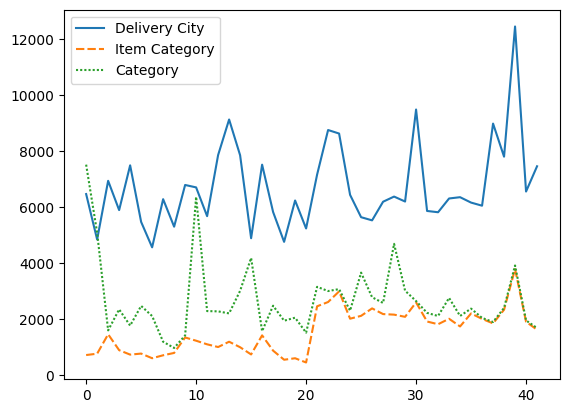

In [81]:
sns.lineplot(df_big)

In [86]:
df_big.to_json()

'{"Order Date":{"0":1719273600000,"1":1719187200000,"2":1719100800000,"3":1719014400000,"4":1718928000000,"5":1718841600000,"6":1718755200000,"7":1718668800000,"8":1718582400000,"9":1718496000000,"10":1718409600000,"11":1718323200000,"12":1718236800000,"13":1718150400000,"14":1718064000000,"15":1717977600000,"16":1717891200000,"17":1717804800000,"18":1717718400000,"19":1717632000000,"20":1717545600000,"21":1717459200000,"22":1717372800000,"23":1717286400000,"24":1717200000000,"25":1717113600000,"26":1717027200000,"27":1716940800000,"28":1716854400000,"29":1716768000000,"30":1716681600000,"31":1716595200000,"32":1716508800000,"33":1716422400000,"34":1716336000000,"35":1716249600000,"36":1716163200000,"37":1716076800000,"38":1715990400000,"39":1715904000000,"40":1715817600000,"41":1715731200000},"Delivery City":{"0":6462,"1":4837,"2":6935,"3":5889,"4":7489,"5":5467,"6":4558,"7":6279,"8":5296,"9":6787,"10":6700,"11":5672,"12":7856,"13":9127,"14":7849,"15":4883,"16":7513,"17":5820,"18":475

In [50]:
df_small.head(5)

,Order Date,Delivery Pincode,Seller Pincode,Provider ID,Seller City,Cancellation Code
0,2024-06-25,0,17,0,17,50
1,2024-06-24,0,19,0,19,124
2,2024-06-23,3,33,0,33,57
3,2024-06-22,1,19,0,19,62
4,2024-06-21,1,89,0,89,57


Jsonify

In [51]:
df_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Order Date     42 non-null     object
 1   Delivery City  42 non-null     object
 2   Item Category  42 non-null     object
 3   Category       42 non-null     object
dtypes: object(4)
memory usage: 1.4+ KB


In [52]:
for col in df_big.columns:
    try:
        if col != "Order Date":
            df_big.loc[:,[col]] = df_big[col].astype(int)
    except:
        pass

In [53]:
test_dict = df_big.head(5).to_dict()

In [54]:
test_dict.keys()

dict_keys(['Order Date', 'Delivery City', 'Item Category', 'Category'])

In [74]:
res_dict = {}
output = []

In [75]:
[val for val in test_dict["Delivery City"].values()]

[6462, 4837, 6935, 5889, 7489]

In [76]:
for key in test_dict.keys():
    if key not in ("Order Date","categories"):
        print(key)
        res_dict = {}
        res_dict["name"] = key
        res_dict["data"] = [val for val in test_dict[key].values()]
        output.append(res_dict)

Delivery City
Item Category
Category


In [77]:
dct["categories"]

[{'name': 'Delivery City', 'data': [6462, 4837, 6935, 5889, 7489]},
 {'name': 'Item Category', 'data': [708, 756, 1450, 882, 723]},
 {'name': 'Category', 'data': [7513, 5079, 1589, 2340, 1760]}]